# Read data and create timeseries using PICES LME

Look at SST, ocean currents, chl-a

In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def weighted_mean_of_masked_data(data_in,data_mask,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean

def weighted_mean_of_data(data_in,data_cond):
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) 
    pixel_area = dA.where(data_cond)  #pixel_area.plot()
    #pixel_area = pixel_area.where(np.isfinite(data_mask))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (data_in * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean


# Read in PICES mask

- Each dataset finds a unique and different way to define lat / lon or order them.
- There is a need for standardization in this area
- The basic PICES mask is -180 to 180 lon and -90 to 90 lat
- Below different maps are created for 0 to 360 lon
- Then each of the two different lon maps are also copied to reverse lat, 90 to -90

In [87]:
#read in mask file
filename = './data/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
#read in mask file
filename = './data/PICES_all_mask360.nc'
ds_pices360 = xr.open_dataset(filename)
ds_pices360.close()

ds_pices_revlat = ds_pices.sortby(ds_pices.lat, ascending = False)
ds_pices360_revlat = ds_pices360.sortby(ds_pices360.lat, ascending = False)



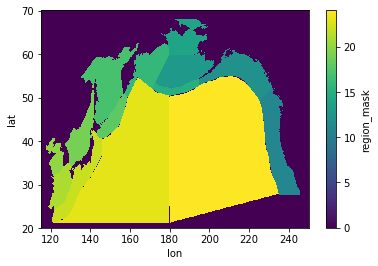

In [101]:
ds_pices360.sel(lon=slice(115,250),lat=slice(20,70)).region_mask.plot()

## Read in SST data

In [90]:
ds = xr.open_dataset('./data/sst.mnmean.nc')
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)
#create sst mean for pices region
iregion=13
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
sst_mean = weighted_mean_of_data(ds.sst,cond)

#make climatology and anomalies using .groupby method
sst_climatology = sst_mean.groupby('time.month').mean('time')
sst_anomalies = sst_mean.groupby('time.month') - sst_climatology

lat range 89.5 -89.5
lon range 0.5 359.5


## Read in wind data

In [92]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdlasFnWind10'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'}).drop({'taux_mean','tauy_mean','curl'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#create  mean for pices region
iregion=13
mask_interp = ds_pices360.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
wnd_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
wnd_climatology = wnd_mean.groupby('time.month').mean('time')
wnd_anomalies = wnd_mean.groupby('time.month') - wnd_climatology


lat range -90.0 90.0
lon range 0.0 359.0


## Testing still

In [93]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorMonthly'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#create  mean for pices region
iregion=13
mask_interp = ds_pices_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
chl_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
chl_climatology = chl_mean.groupby('time.month').mean('time')
chl_anomalies = chl_mean.groupby('time.month') - chl_climatology


lat range 89.979164 -89.979164
lon range -179.97917 179.97917


In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar'
ds = xr.open_dataset(aggr_url).isel(depth=0).rename({'latitude':'lat','longitude':'lon'}).drop({'um','vm'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

ds = ds.sel(lon=slice(115,250),lat=slice(70,20))

#create  mean for pices region
iregion=13
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
cur_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
cur_climatology = cur_mean.groupby('time.month').mean('time')
cur_anomalies = cur_mean.groupby('time.month') - cur_climatology


lat range 80.0 -80.0
lon range 20.0 420.0


In [ ]:
                ds_mean['spd']=(ds_mean.uwnd**2+ds_mean.vwnd**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.vwnd,ds_mean.uwnd)* 180./pi                
